# Código para extraer informacion académica de publicaciones a partir de los GRUPLAC - MinCiencias

**Código Desarrollado por**: *David Sierra Porta*

Este código extrae información a partir de las direcciones web de los formularios de GrupLAC de Minciencias. En la primera version sólo se obtiene informacion de publicaciones científicas académicas en journals reconocidos por MinCiencias ("Publicaciones") y también en otros journals no reconocidos ("Otras Publicaciones"); y tambien "Libros", "Capítulos de Libros" y "Libros de Formación" escritos o co-escritos por los investigadores.
- Artículos publicados, Otros artículos publicados [TODOS TIENEN ISSN]
- Libros publicados, Capítulos de libro publicados, Libros de formación [TODOS TIENEN ISBN]

Las salidas de este código se guardan en dataframes que luego se exportan a csv o archivos excel.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import urllib3
import numpy as np
# Desactivar la advertencia sobre certificados SSL
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [2]:
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000003447"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000003448"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000003446"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000003457"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000003455"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000001177"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000000997"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000001045"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000001098"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000001877"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000010193"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000012959"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000014495"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000018125"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000018273"
#url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000018670"

#url="https://scienti.minciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000010193"# GIGMA
url="https://scienti.colciencias.gov.co/gruplac/jsp/visualiza/visualizagr.jsp?nro=00000000003446"# GAICO


In [3]:
#def get_page(url=url):
#    response = requests.get(url)
#    if response.status_code != 200:
#        print("Error al acceder a la página")
#    soup = BeautifulSoup(response.content, 'html.parser')
#    return soup

def get_page(url=url):
    response = requests.get(url, verify=False)
    if response.status_code != 200:
        print("Error al acceder a la página")
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

In [4]:
soup=get_page()

In [5]:
def get_datos_basicos(soup=soup):
    # Extraer el texto usando la clase específica
    elemento = soup.find('span', class_='celdaEncabezado')
    if elemento:
        nombre_grupo = elemento.text.strip()
        print("Nombre del grupo:", nombre_grupo)
    else:
        print("Elemento no encontrado.")
    # Search for headers in web document "Datos básicos"
    basic_info = {}
    header = soup.find('td', class_='celdaEncabezado', string='Datos básicos')
    if header:
        table = header.find_parent('table')  # Obtener la tabla asociada al encabezado
        if table:
            rows = table.find_all('tr')[1:]  # Omitir la fila del encabezado
            for row in rows:
                cols = row.find_all('td')
                if len(cols) == 2:
                    key = cols[0].get_text(strip=True)
                    value = cols[1].get_text(strip=True)
                    basic_info[key] = value
    data_i=pd.DataFrame(basic_info.items(),columns=["Dato","Valor"])
    data_i.set_index("Dato",inplace=True)
    # New row to add
    new_row = pd.DataFrame({'Valor':nombre_grupo},index=["Nombre del Grupo"])
    # Concatenate the new row with the DataFrame
    data_i = pd.concat([new_row, data_i], ignore_index=False)
    a=data_i["Valor"].loc["Clasificación"].split("con")
    #print(len(a))
    if a==[""]:
        data_i.loc["Clasificación"]="No clasificado"
    else:
        data_i.loc["Clasificación"]=a[0]+" "+a[1]
    return data_i

In [6]:
datos_basicos=get_datos_basicos()
datos_basicos

Nombre del grupo: Grupo de Automatización Industrial y Control - GAICO


,Valor
Nombre del Grupo,Grupo de Automatización Industrial y Control -...
Año y mes de formación,1998 - 2
Departamento - Ciudad,BOLÍVAR - CARTAGENA DE INDIAS
Líder,José Luis Villa Ramirez
¿La información de este grupo se ha certificado?,Si el día 2020-01-09
Página web,http://www.utb.edu.co/investigaciones/grupo/46
E-mail,jvilla@utb.edu.co
Clasificación,B vigencia hasta la publicación de los result...
Área de conocimiento,Ingeniería y Tecnología -- Ingenierías Eléctri...
Programa nacional de ciencia y tecnología,"Ciencia, Tecnología e Innovación en Ingeniería"


In [7]:
def extract_articles_table(header_text):
    # Buscar el encabezado específico
    articles = []
    header = soup.find('td', class_='celdaEncabezado', string=header_text)
    if header:
        table = header.find_parent('table')  # Obtener la tabla asociada al encabezado
        if table:
            rows = table.find_all('tr')  # Obtener todas las filas de la tabla
            article_data = []
            
            for row in rows:
                cols = row.find_all('td')
                if len(cols) >= 2:
                    raw_text = cols[1].decode_contents().strip()  # Extraer el HTML manteniendo estructura
                    raw_text_clean = BeautifulSoup(raw_text, 'html.parser').get_text(" ", strip=True)
                    
                    # Detectar el inicio de un nuevo artículo por el formato numérico "1.- "
                    if re.match(r'\d+\.\-', raw_text_clean):
                        if article_data:  # Si hay datos acumulados, procesar el artículo previo
                            articles.append(process_article(article_data))
                        article_data = [raw_text_clean]  # Iniciar nuevo artículo
                    else:
                        article_data.append(raw_text_clean)
            
            if article_data:  # Procesar el último artículo capturado
                articles.append(process_article(article_data))
    
    return pd.DataFrame(articles) if articles else None

def process_article(article_data):
    """ Procesa un artículo estructurado en varias líneas y extrae sus atributos """
    tipo_publicacion = re.search(r'(Publicado en .+?):', article_data[0])
    titulo = re.sub(r'\d+\.\- Publicado en .*?: ', '', article_data[0])
    revista_info = re.search(r', (.+?) ISSN:', " ".join(article_data))
    issn = re.search(r'ISSN:?\s*([\dA-Z]{4}-[\dA-Z]{4})', " ".join(article_data))
    anio = re.search(r'ISSN:?\s*[\dA-Z]{4}-[\dA-Z]{4},\s*(\d{4})', " ".join(article_data))
    volumen = re.search(r'vol:\s*(\d+)', " ".join(article_data))
    fasciculo = re.search(r'fasc:\s*(\d+)', " ".join(article_data))
    paginas = re.search(r'págs:\s*(\d+ [\-–] ?\d*)', " ".join(article_data))
    doi_match = re.search(r'DOI:\s*([^\s]+)', " ".join(article_data))
    doi = doi_match.group(1).strip() if doi_match and 'Autores:' not in doi_match.group(1) else ""
    autores = re.search(r'Autores:\s*(.*)', " ".join(article_data))
    
    return {
        "Tipo de Publicación": tipo_publicacion.group(1) if tipo_publicacion else "",
        "Título": titulo.strip() if titulo else "",
        "Revista": revista_info.group(1).strip() if revista_info else "",
        "ISSN": issn.group(1) if issn else "",
        "Año": anio.group(1) if anio else "",
        "Volumen": volumen.group(1) if volumen else "",
        "Fascículo": fasciculo.group(1) if fasciculo else "",
        "Páginas": paginas.group(1) if paginas else "",
        "DOI": doi,
        "Autores": autores.group(1).strip() if autores else ""
    }

In [8]:
df_articles = extract_articles_table("Artículos publicados")
#df_articles

In [9]:
df_other_articles = extract_articles_table("Otros artículos publicados")
Titulo,Tipo=[],[]
for i in range(len(df_other_articles)):
    Titulo.append(df_other_articles["Título"].str.split(": ")[i][1])
    a=df_other_articles["Título"].str.split(": ")[i][0]
    Tipo.append(a.split("- ")[1])
df_other_articles["Título"]=Titulo
df_other_articles["Tipo de Publicación"]=Tipo
#df_other_articles

In [10]:
df_other_articles

,Tipo de Publicación,Título,Revista,ISSN,Año,Volumen,Fascículo,Páginas,DOI,Autores
0,Revista de divulgación,"Implementación de una RTU en FPGA Colombia, R...",Revista Virtual De La Facultad De Ingeniería Y...,2215-8456,2010,1,,,,"JORGE ELIECER DUQUE PARDO, LUIS ENRIQUE ACOSTA..."
1,Revista de divulgación,"LA TELEFONIA POR IP Colombia, Contraste. Educa...","Contraste. Educación, Región Y Desarrollo",1794-7464,2005,,,12 - 12,,GONZALO LOPEZ VERGARA


In [11]:
df_Articulos_todos=pd.concat([df_articles,df_other_articles]).reset_index()
df_Articulos_todos["Año"]=pd.to_numeric(df_Articulos_todos["Año"]).astype(np.int64,errors="ignore")
#df_Articulos_todos

In [12]:
def extract_books_table(header_text):
    # Buscar el encabezado específico
    books = []
    header = soup.find('td', class_='celdaEncabezado', string=header_text)
    if header:
        table = header.find_parent('table')  # Obtener la tabla asociada al encabezado
        if table:
            rows = table.find_all('tr')  # Obtener todas las filas de la tabla
            book_data = []
            
            for row in rows:
                cols = row.find_all('td')
                if len(cols) >= 2:
                    raw_text = cols[1].decode_contents().strip()  # Extraer el HTML manteniendo estructura
                    raw_text_clean = BeautifulSoup(raw_text, 'html.parser').get_text(" ", strip=True)
                    
                    # Detectar el inicio de un nuevo libro por el formato numérico "1.- "
                    if re.match(r'\d+\.\-', raw_text_clean):
                        if book_data:  # Si hay datos acumulados, procesar el libro previo
                            books.append(process_book(book_data))
                        book_data = [raw_text_clean]  # Iniciar nuevo libro
                    else:
                        book_data.append(raw_text_clean)
            
            if book_data:  # Procesar el último libro capturado
                books.append(process_book(book_data))
    
    return pd.DataFrame(books) if books else None

def process_book(book_data):
    """ Procesa un libro estructurado en varias líneas y extrae sus atributos """
    tipo_publicacion = re.search(r'(Libro .+?) :', book_data[0])
    titulo = re.sub(r'\d+\.\- Libro .+? : ', '', book_data[0])
    pais = re.search(r':\s*(.+?),\s*\d{4}', book_data[0])
    anio = re.search(r',\s*(\d{4}),', book_data[0])
    isbn = re.search(r'ISBN:\s*([0-9\-]+)', book_data[0])
    editorial = re.search(r'Ed\.\s*(.+?)(?:Autores:|$)', book_data[0])
    autores = re.search(r'Autores:\s*(.*)', " ".join(book_data))

    return {
        "Tipo de Publicación": tipo_publicacion.group(1) if tipo_publicacion else "",
        "Título": titulo.strip() if titulo else "",
        "País": pais.group(1).strip() if pais else "",
        "Año": anio.group(1).strip() if anio else "",
        "ISBN": isbn.group(1).strip() if isbn else "",
        "Editorial": editorial.group(1).strip() if editorial else "",
        "Autores": autores.group(1).strip() if autores else ""
    }

In [13]:
df_books = extract_books_table(" Libros publicados ")
#df_books

In [14]:
df_other_books = extract_books_table("Capítulos de libro publicados ")
Titulo,Tipo=[],[]
for i in range(len(df_other_books)):
    Titulo.append(df_other_books["Título"].str.split(" :")[i][1])
    a=df_other_books["Título"].str.split(": ")[i][0]
    Tipo.append(a.split("- ")[1])
df_other_books["Título"]=Titulo
df_other_books["Tipo de Publicación"]=Tipo
#df_other_books

In [15]:
df_Libros_todos=pd.concat([df_books,df_other_books]).reset_index()
df_Libros_todos["Año"]=pd.to_numeric(df_Libros_todos["Año"]).astype(np.int64,errors="ignore")
#df_Libros_todos

# Probando....

In [16]:
import matplotlib.pyplot as plt
import numpy as np

<Axes: >

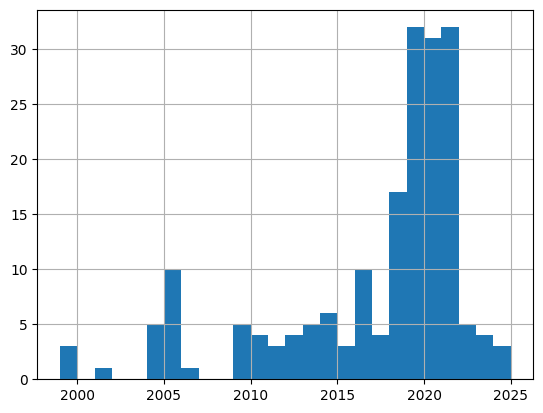

In [17]:
df_Articulos_todos["Año"].hist(bins=np.arange(df_Articulos_todos["Año"].min(),df_Articulos_todos["Año"].max()+1,1))

In [18]:
#Ajustando años....
df_Articulos_todos["Grupo"]=datos_basicos.loc["Nombre del Grupo"]["Valor"]
df_Libros_todos["Grupo"]=datos_basicos.loc["Nombre del Grupo"]["Valor"]

In [19]:
# Guardando datos in excelente file...
# determining the name of the file
file_name = '{}.xlsx'.format(datos_basicos.loc["Nombre del Grupo"]["Valor"])

# creating an ExcelWriter object
with pd.ExcelWriter(file_name) as writer:
    # writing to the 'Employee' sheet
    datos_basicos.to_excel(writer, sheet_name='Datos Básicos', index=True)
    df_Articulos_todos.to_excel(writer, sheet_name='Artículos', index=False)
    df_Libros_todos.to_excel(writer, sheet_name='Libros', index=False)
print('DataFrames are written to Excel File successfully.')

DataFrames are written to Excel File successfully.


In [20]:
import unicodedata

def normalize_author(author):
    author = author.lower().strip()
    author = unicodedata.normalize('NFD', author)
    author = ''.join([c for c in author if unicodedata.category(c) != 'Mn'])  # Quita acentos
    author = ' '.join(sorted(author.split()))  # Ordena nombres para evitar diferente orden
    return author

# Obtener autores únicos
autores_set = set()

for autores in df_Articulos_todos["Autores"]:
    autores_lista = autores.split(",")
    for autor in autores_lista:
        autor_norm = normalize_author(autor)
        autores_set.add(autor_norm)

# Convertir a lista ordenada para verificar
autores_unicos = sorted(list(autores_set))
print("Autores únicos normalizados:")
print(autores_unicos)

Autores únicos normalizados:
['abel gutierrez', 'acevedo oscar patino', 'acosta enrique galvan luis', 'acuna camacho oscar segundo', 'adolfo daniel jimenez maya', 'aguirre isabela marina mercado', 'ahn hyochun', 'alain gauthier sellier', 'alberto carlos ramirez vanegas', 'alberto garcia luis zapateiro', 'alberto hincapie isaza ricardo', 'alberto mario mesias rios', 'alberto miguel triana urina', 'alejandra colorado luz magre', 'alejandro garces ruiz', 'alejandro grajales otalvaro', 'alexander cabrera molina', 'alexander giraldo guzman jader', 'alexander jauder ocampo toro', 'alexandra lenny perez romero', 'alfonso andres munoz rosales', 'andrea heredia jenny rolon', 'andres arias londono', 'andres arteaga jhacson meza', 'andres carlos paja ramos', 'andres del jorge rio sierra', 'andres escobar felipe santoya', 'andres guillermo hernandez marrugo', 'andres ramirez raul vargas', 'angarita arjona javier ricardo', 'angel cabal miguel rodriguez', 'annika kunnasvirta', 'antonio contreras jua

In [30]:
# Crear un DataFrame vacío con autores únicos y años
anios = sorted(df_Articulos_todos["Año"].dropna().unique())
conteo_autores_anios = pd.DataFrame(0, index=autores_unicos, columns=anios)

# Llenar DataFrame con conteos
for _, row in df_Articulos_todos.iterrows():
    if pd.isna(row["Año"]) or pd.isna(row["Autores"]):
        continue
    anio = row["Año"]
    autores_lista = row["Autores"].split(",")
    for autor in autores_lista:
        autor_norm = normalize_author(autor)
        conteo_autores_anios.loc[autor_norm, anio] += 1

# Mostrar tabla final
conteo_autores_anios.reset_index(inplace=True)
conteo_autores_anios.rename(columns={'index': 'Autor'}, inplace=True)
conteo_autores_anios["Suma"]=conteo_autores_anios.drop(columns=["Autor"]).sum(axis=1)

#print("Tabla de conteo de publicaciones por autor y año:")
conteo_autores_anios.sort_values(by="Suma",ascending=False)

,Autor,1999.0,2001.0,2004.0,2005.0,2006.0,2009.0,2010.0,2011.0,2012.0,...,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0,Suma
80,danilo giraldo montoya oscar,0,0,0,0,0,0,0,0,0,...,0,15,26,25,25,0,0,0,0,91
109,gil gonzalez julian walter,0,0,0,0,0,0,0,0,0,...,0,5,18,17,6,0,0,0,0,46
101,fernando grisales luis norena,0,0,0,0,0,0,0,0,0,...,0,5,10,7,6,0,0,0,0,28
14,alejandro garces ruiz,0,0,0,0,0,0,0,0,0,...,0,7,10,1,1,0,0,0,0,19
71,contreras helena ortiz sonia,0,0,0,4,0,2,1,2,1,...,0,0,0,1,3,1,0,0,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,bustillo ciro fernando lecompte,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
52,brewer david enrique ramirez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
51,book gregory,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
142,schwede sebastian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
